# Introducción a las redes neuronales con ejemplos numéricos

- Diagrama general del aprendizajo supervisado en ML:

![title](https://volcanohong.github.io/content/images/2016/ml_process.png)

- ¿Qué es una red neuronal?

Según Wiki: es un modelo computacional vagamente inspirado en el comportamiento observado en su homólogo biológico.

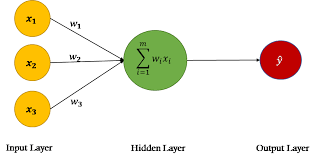

- ¿De qué sirve una sola neurona?

In [7]:
import numpy as np
from time import time
import tensorflow.keras as K
import random

### Para explicar cada parte, usaremos la implementación de Michael Nielsen en su libro Neural Networks and Deep Learning:

- Libro de acceso abierto: http://neuralnetworksanddeeplearning.com
- La presente versión ha sido modificada para fines didácticos:
    - Traducida al español.
    - Adaptada para regresión.
    - Adaptada a Python 3.

Consíderese lo siguiente:

- Cada conexión tiene un peso.
- Cada neurona tiene un bias. 
- Función de costo: 
$C(w, b) ≡ \frac{1}{2} \Sigma_x || y(x) − a(x,w,b)||^2$, donde a es la predicción de la RNA.
- Métodos analíticos de minimización no son útiles para muchas variables.
- Se requiere un algoritmo para minimizar la función de costo: descenso del gradiente

In [63]:
class Network(object):
    def __init__(self, sizes):
        """
            size es una lista que 
            debe contener el número de neuronas para cada una de las tres
            paredes de la red neuronal
        """
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        print("Forma del np.array con bias (uno por cada conexión): {}".format(np.shape(self.biases)))
        print(self.biases)
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        print("Forma del np.array de pesos: {}".format(np.shape(self.weights)))
        print(self.weights)


    def feedforward(self, a):
        """
           Propagación hacia adelante: realiza la suma ponderada a través de las capas.
           Regresa la salida de la red neuronal.
           a es la entrada de la red neuronal.
        """
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """
        Stochastic Gradient Descent: Desenso del gradiente estocástico.
        
        - trainig_data: conjunto de entrenamiento, x var independientes, y salida esperada
        (var dependiente).
        - epochs: número de épocas.
        - mini_batch_size: 
        - eta: learning rate
        """
        if test_data: 
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}").format(
                    j, self.evaluate(test_data), n_test)
            else:
                print ("Epoch {0} complete").format(j)

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """
        Evalúa rendimiento de la red neuronal
        """
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """
        Derivadas parciales
        \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))



In [64]:
net = Network([2,10,1])

Forma del np.array con bias (uno por cada conexión): (2,)
[array([[ 1.3893499 ],
       [ 0.03773412],
       [ 0.87777073],
       [-1.29035399],
       [ 0.62150626],
       [ 0.45876255],
       [ 0.24622552],
       [ 0.31529999],
       [-1.4907041 ],
       [ 0.4296312 ]]), array([[0.44688886]])]
Forma del np.array de pesos: (2,)
[array([[ 0.15211633,  0.92446259],
       [-0.54863251,  0.40768956],
       [ 0.1186077 , -0.78834051],
       [-0.23009001, -0.34078913],
       [ 0.264081  , -1.21091026],
       [ 0.31580243,  0.4014537 ],
       [ 0.02581296, -1.52054939],
       [ 1.98471474,  2.35033424],
       [ 0.70012123, -1.25257547],
       [-1.44687261,  0.27042355]]), array([[-0.48108431,  1.877022  ,  0.53341453, -0.89379251, -2.30113523,
        -0.85283299, -0.24365736, -0.51302387,  0.5164416 , -0.50213275]])]


In [71]:
data = [[1,2,3,4,5,6],[2,4,6,8,10,12]]

In [72]:
net.SGD(training_data=data, epochs=10, eta=0.5, mini_batch_size=8)

ValueError: too many values to unpack (expected 2)